# Perplexity Plots

Plots perplexities for larger range of languages.

In [6]:
# For importing utils
import sys
sys.path.append("..")

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from utils import PERTURBATIONS
from glob import glob

In [8]:
def plot_geometric_mean_perplexities(ax_i, ax, file_info, title, model_type, checkpoints):
    
    results_path = 'perplexity_results/{}_100M/*{}*.csv'

    for file_data in file_info:
        model_perturb, marker, linestyle, legend_name = file_data
        all_files = glob(results_path.format(model_perturb, model_type))
        assert len(all_files) == 3, f"Expected 3 files, found {len(all_files)} for {model_perturb}"

        all_seeds_gmeans = []
        for file in all_files:
            df = pd.read_csv(file)
            gmeans = []

            # Calculate geometric means for each checkpoint
            for ckpt in checkpoints:
                gmeans.append(stats.gmean(df[f"Perplexities (ckpt {ckpt})"]))

            all_seeds_gmeans.append(gmeans)

        all_seeds_gmeans = np.array(all_seeds_gmeans)
        means = np.mean(all_seeds_gmeans, axis=0)

        ci = None
        if len(all_files) > 1:
            sems = stats.sem(all_seeds_gmeans, axis=0)
            # Calculate confidence interval using t-distribution
            ci_lower, ci_upper = stats.t.interval(0.95, df=len(all_files)-1,
                                                loc=means, scale=sems)
            ci = (ci_upper - ci_lower) / 2

        # Plotting
        ax.errorbar(checkpoints, means, ci, marker=marker, 
                    color=PERTURBATIONS[model_perturb]["color"],
                    linestyle=linestyle, label=legend_name)

    ax.set_title(title)
    if ax_i == 0:
        ax.set_ylabel("Geometric Mean Perplexity", fontsize=12)
    
    if title == "*Shuffle":
        ax.legend(fontsize=8, framealpha=1)
    else:
        ax.legend(fontsize=9, framealpha=1)
    ax.grid(True, color="lightgray")

In [9]:
def plot_perplexities_grouped(file_infos, titles, model_type, checkpoints):
    
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(1, len(file_infos), figsize=(20, 5), sharey=True, sharex=True)
    fig.subplots_adjust(wspace=0.15)
    fig.supxlabel("Training Steps", fontsize=12)
    
    axs_flat = axs.flatten()
    
    # Call individual plot function with different parameters for each subplot
    for i, (file_info, title) in enumerate(zip(file_infos, titles)):
        plot_geometric_mean_perplexities(
            i, axs_flat[i], file_info, title, model_type, checkpoints)
        
    if model_type == "gpt2":
        model_type_title = "GPT-2 with Absolute Position Embeddings"
    elif model_type == "alibi":
        model_type_title = "GPT-2 with ALiBi"
    elif model_type == "rope":
        model_type_title = "GPT-2 with RoPE"
    plt.suptitle(f"Perplexities for {model_type_title}", fontsize=16)

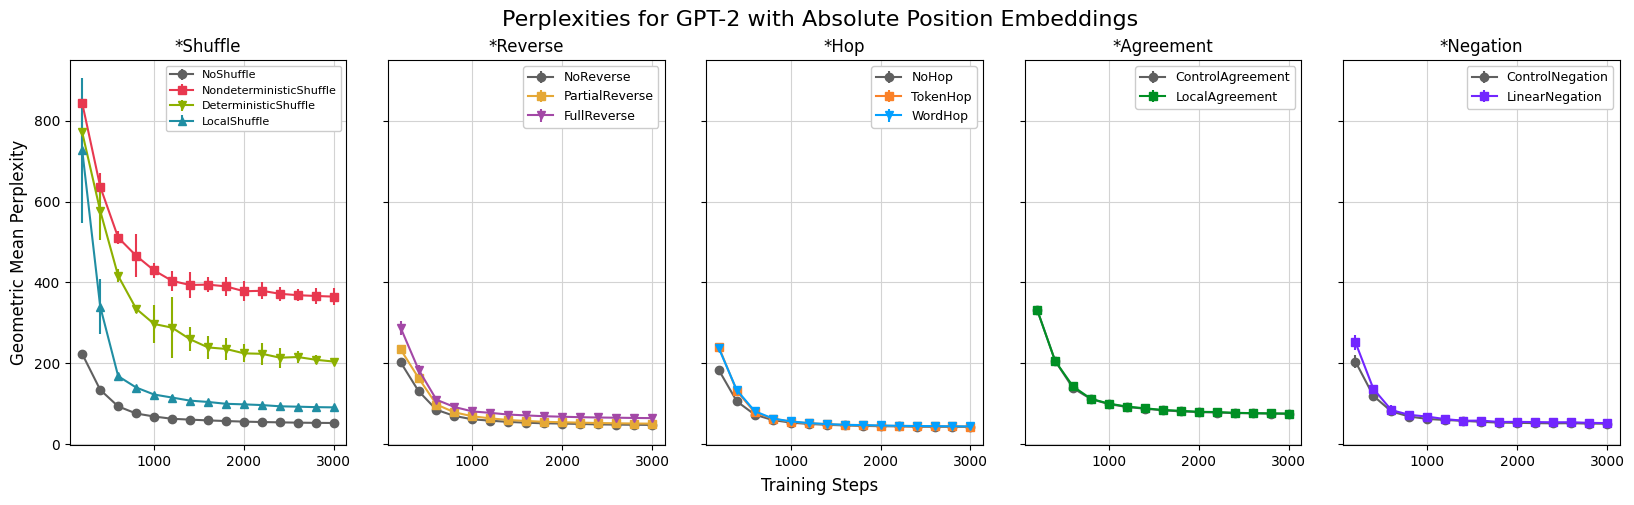

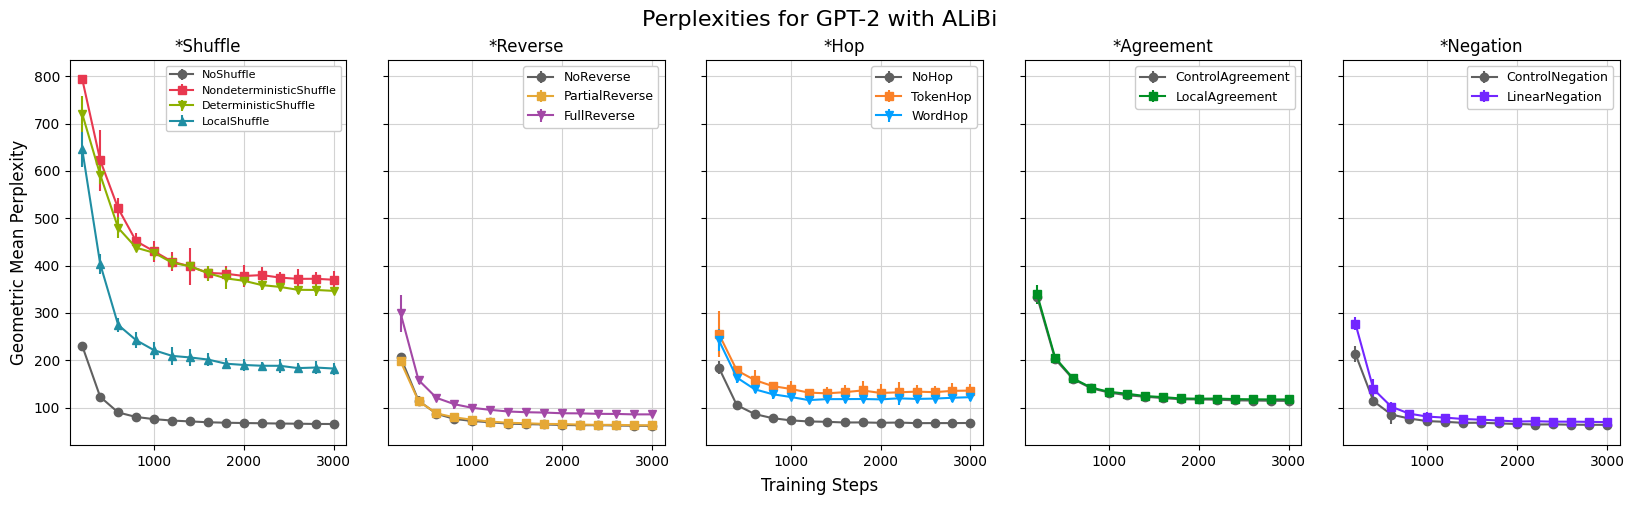

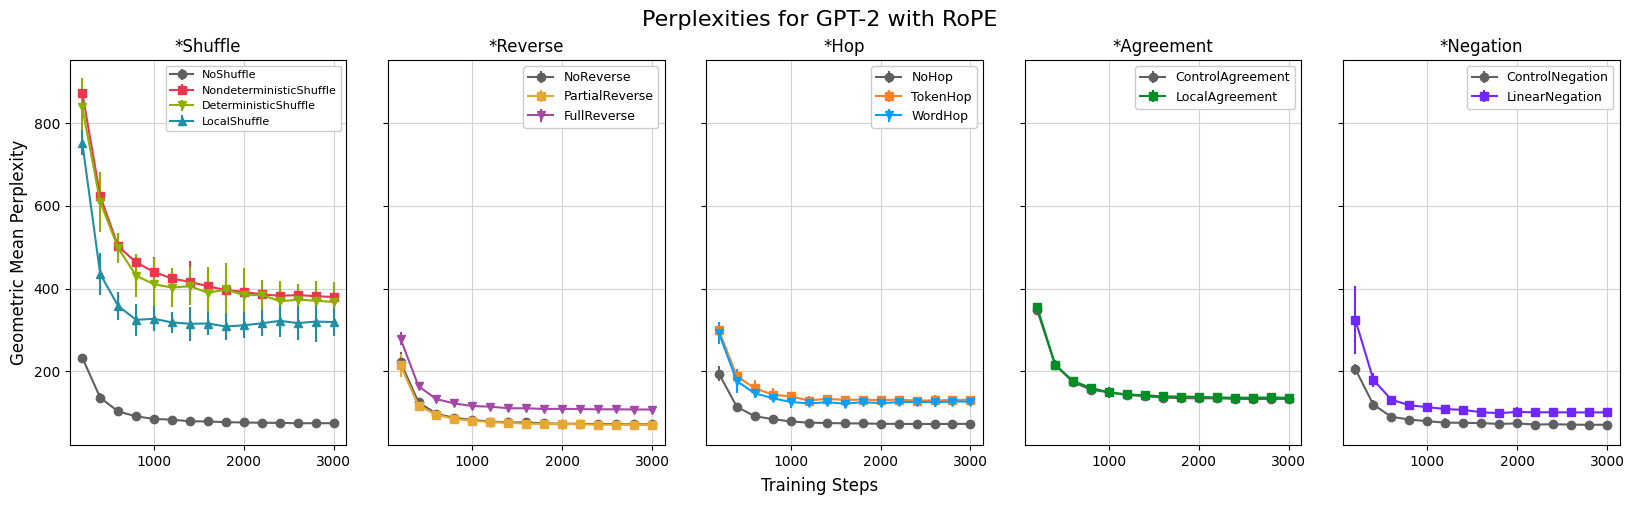

In [10]:
MAX_TRAINING_STEPS = 3000
CHECKPOINTS = list(range(200, MAX_TRAINING_STEPS+1, 200))


shuffle_file_info = [
    ("shuffle_control", 'o', "-", 'NoShuffle'),
    ("shuffle_nondeterministic", "s", "-", 'NondeterministicShuffle'),
    ("shuffle_deterministic57", "v", "-", 'DeterministicShuffle'),
    ("shuffle_local3", "^", "-", 'LocalShuffle'),
]
reverse_file_info = [
    ("reverse_control", 'o', "-", 'NoReverse'),
    ("reverse_partial", "s", "-", 'PartialReverse'),
    ("reverse_full", 'v', "-", 'FullReverse'),
]
hop_file_info = [
    ("hop_control", 'o', "-", 'NoHop'),
    ("hop_tokens4", "s", "-", 'TokenHop'),
    ("hop_words4", 'v', "-", 'WordHop'),
]
agree_file_info = [
    ("agreement_control", 'o', "-", 'ControlAgreement'),
    ("agreement_local", "s", "-", 'LocalAgreement'),
]
neg_file_info = [
    ("negation_control", 'o', "-", 'ControlNegation'),
    ("negation_linear", "s", "-", 'LinearNegation'),
]

# Plot
plot_perplexities_grouped([shuffle_file_info, reverse_file_info, hop_file_info, agree_file_info, neg_file_info], 
                          ["*Shuffle", "*Reverse", "*Hop", "*Agreement", "*Negation"],
                          "gpt2", CHECKPOINTS)
plot_perplexities_grouped([shuffle_file_info, reverse_file_info, hop_file_info, agree_file_info, neg_file_info],
                          ["*Shuffle", "*Reverse", "*Hop", "*Agreement", "*Negation"],
                          "alibi", CHECKPOINTS)
plot_perplexities_grouped([shuffle_file_info, reverse_file_info, hop_file_info, agree_file_info, neg_file_info],
                          ["*Shuffle", "*Reverse", "*Hop", "*Agreement", "*Negation"],
                          "rope", CHECKPOINTS)
# plt.savefig("figures/perplexities.pdf", format="pdf", bbox_inches="tight")